In [3]:
!pip install pandasql

In [2]:
import sqlalchemy as sql
import psycopg2 
import pandas.io.sql as sqlio
import pandas as pd
from functools import reduce
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf

In [28]:
engine = sqlalchemy.create_engine('postgres_URI')

In [29]:
query = """
with equity_avg as (
select account_number , percentile_cont(0.5) within group (order by avg_equity) as median_equity
from (
select account_number, sum(max_equity_month)/count(month_of) as avg_equity
from (
select a.account_number,date_trunc('month', asof) as month_of, max(db.equity) as max_equity_month
from daily_balances db 
left join accounts A on a.id = db.account_id
where a.correspondent in ('LPCA', '', 'NULL')
and asof between '2022-05-01' and '2022-06-01'
and db.equity > 0
and a.account_number is not NULL
group by 1, 2
)query1
group by 1
)query2
group by 1
),

mean_orders as (
select orders.account,  count(orders.id)/count(distinct date_trunc('day', filled_at)) as orders_per_day
from orders 
left join accounts A on a.account_number = orders.account 
left join assets ast ON ast.id::uuid=orders.asset_id::uuid
where filled_at::date between '2022-05-01' and '2022-06-01'
and filled_at is not NULL
and ast.class = 'us_equity'
and orders.account not in ('NULL', '', 'NOHODL')
and correspondent in ('LPCA', '', 'NULL')
group by 1

),

order_list as (

select all_equities_table_columns
from equities_table
),


cte1 as (
select *
from order_list
where conditions = x
),



final_data as (
select
account_number,
sum(qty*rebate_amount) as tot_rebates
from cte1

group by 1),

final_segmentation as (

select mo.account, fd.tot_rebates,
case when orders_per_day < 5 and median_equity < 25000 then 'LOW AUM LOW FREQ'  
     when (orders_per_day between 5 and 100) and median_equity < 25000 then 'LOW AUM MED FREQ'
     when orders_per_day > 100 and median_equity < 25000 then 'LOW AUM HIGH FREQ'
     when orders_per_day < 5 and (median_equity between 25000 and 250000) then 'MED AUM LOW FREQ'
     when (orders_per_day between 5 and 100) and (median_equity between 25000 and 250000) then 'MED AUM MED FREQ'
     when orders_per_day > 100 and (median_equity between 25000 and 250000) then 'MED AUM HIGH FREQ'
     when orders_per_day < 5 and median_equity >250000 then 'HIGH AUM LOW FREQ'
     when (orders_per_day between 5 and 100) and median_equity >250000 then 'HIGH AUM MED FREQ'
     when orders_per_day > 100 and median_equity >250000 then 'HIGH AUM HIGH FREQ'
     else 'other' end as data_group
     
from mean_orders mo
left join equity_avg ea on ea.account_number = mo.account 
left join final_data fd on fd.account_number = mo.account)



select count(distinct account) as total_accounts ,  sum(tot_rebates) as total_revenue, data_group
from final_segmentation
group by 3


"""

In [30]:
df = pd.read_sql_query(query, engine)

In [6]:
df['revenue_account'] = df['total_revenue']/df['total_accounts']

In [7]:
df = df.sort_values(by='total_revenue', ascending = False)

In [8]:
total_df = df[['data_group', 'total_revenue', 'revenue_account']]

In [9]:
total_df = total_df.rename(columns={"total_revenue":"may_revenue", "revenue_account":"may_revenue_account"})

In [12]:
df2 = pd.read_sql_query(query2, engine)

In [13]:
df2['revenue_account'] = df2['total_revenue']/df2['total_accounts']

In [14]:
total_df = total_df.merge(df2[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"april_revenue", "revenue_account":"april_revenue_account"})

In [16]:
df3 = pd.read_sql_query(query3, engine)

In [17]:
df3['revenue_account'] = df3['total_revenue']/df3['total_accounts']

In [18]:
total_df = total_df.merge(df3[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"march_revenue", "revenue_account":"march_revenue_account"})

In [20]:
df4 = pd.read_sql_query(query4, engine)

In [21]:
df4['revenue_account'] = df4['total_revenue']/df4['total_accounts']

In [22]:
total_df = total_df.merge(df4[['data_group','total_revenue', 'revenue_account']], on='data_group', how='left')
total_df = total_df.rename(columns={"total_revenue":"february_revenue", "revenue_account":"february_revenue_account"})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MED AUM HIGH FREQ'),
  Text(1, 0, 'MED AUM MED FREQ'),
  Text(2, 0, 'HIGH AUM MED FREQ'),
  Text(3, 0, 'HIGH AUM HIGH FREQ'),
  Text(4, 0, 'HIGH AUM LOW FREQ'),
  Text(5, 0, 'MED AUM LOW FREQ'),
  Text(6, 0, 'LOW AUM MED FREQ'),
  Text(7, 0, 'LOW AUM LOW FREQ'),
  Text(8, 0, 'LOW AUM HIGH FREQ'),
  Text(9, 0, 'other')])

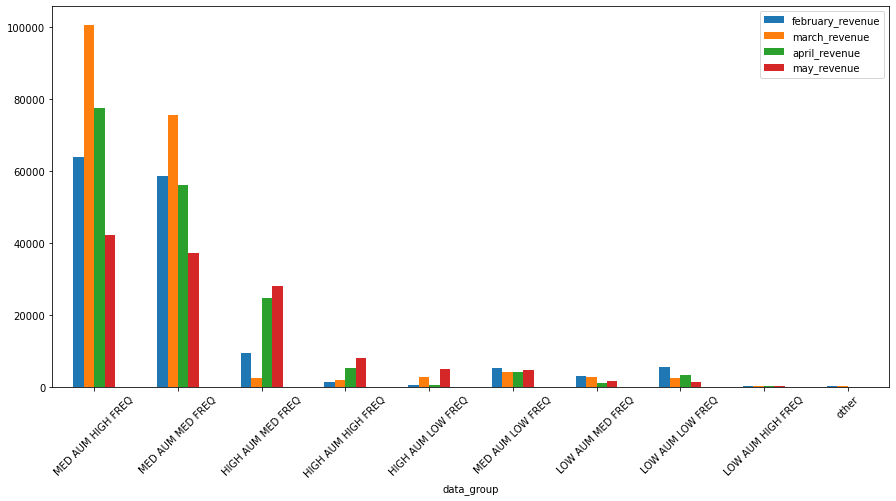

In [24]:
total_df.plot(x='data_group', y = ['february_revenue','march_revenue', 'april_revenue', 'may_revenue'],
        kind='bar',
        stacked=False,
         figsize=(15,7) )
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MED AUM HIGH FREQ'),
  Text(1, 0, 'MED AUM MED FREQ'),
  Text(2, 0, 'HIGH AUM MED FREQ'),
  Text(3, 0, 'HIGH AUM HIGH FREQ'),
  Text(4, 0, 'HIGH AUM LOW FREQ'),
  Text(5, 0, 'MED AUM LOW FREQ'),
  Text(6, 0, 'LOW AUM MED FREQ'),
  Text(7, 0, 'LOW AUM LOW FREQ'),
  Text(8, 0, 'LOW AUM HIGH FREQ'),
  Text(9, 0, 'other')])

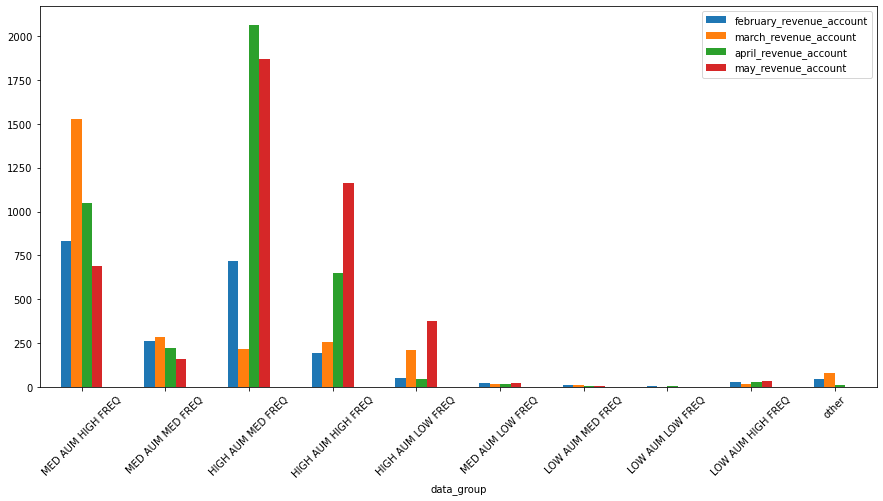

In [25]:
total_df.plot(x='data_group', y = ['february_revenue_account','march_revenue_account', 'april_revenue_account', 'may_revenue_account'],
        kind='bar',
        stacked=False,
         figsize=(15,7) )
plt.xticks(rotation = 45)

In [34]:
total_df.head()

,data_group,may_revenue,may_revenue_account,april_revenue,april_revenue_account,march_revenue,march_revenue_account,february_revenue,february_revenue_account
0,MED AUM HIGH FREQ,42218.700715,692.109848,77484.375750,1047.086159,100613.864390,1524.452491,63837.469140,829.058041
1,MED AUM MED FREQ,37067.047070,158.406184,56033.883390,220.605840,75624.983985,283.239640,58671.205050,260.760911
2,HIGH AUM MED FREQ,28036.639200,1869.109280,24787.076630,2065.589719,2402.079200,218.370836,9319.641175,716.895475
3,HIGH AUM HIGH FREQ,8128.134550,1161.162079,5193.236045,649.154506,2030.423170,253.802896,1341.110980,191.587283
4,HIGH AUM LOW FREQ,4865.376000,374.259692,509.144000,46.285818,2721.238000,209.326000,580.858400,52.805309


In [95]:
df_1 = pd.read_csv('med_aum_high_freq.csv')

In [96]:
df_1['ds'] = pd.to_datetime(df_1['ds'])

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [84]:
y = df_1['y']

In [85]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

In [86]:
ARMAmodel = ARMAmodel.fit()

In [92]:
y_pred = ARMAmodel.get_forecast(2)
y_pred_df = y_pred.conf_int(alpha = 0.05) 

In [88]:
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

In [93]:
y_pred_out = y_pred_df["Predictions"] 

4    30341.243619
5    21986.628945
Name: Predictions, dtype: float64

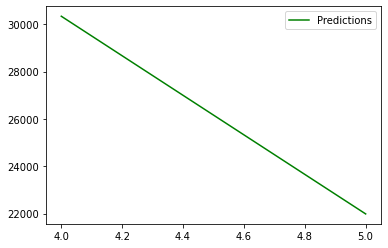

In [91]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [99]:
y = df_1['y2']

In [100]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(2)
y_pred_df = y_pred.conf_int(alpha = 0.05) 

y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

y_pred_out = y_pred_df["Predictions"] 

In [101]:
y_pred_out

4    634.845525
5    364.639682
Name: Predictions, dtype: float64

In [111]:
df_2 = pd.read_csv('values.csv')

In [113]:
df_2['ds'] = pd.to_datetime(df_2['ds'])
y = df_2['y']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(2)
y_pred_df = y_pred.conf_int(alpha = 0.05) 

y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

y_pred_out = y_pred_df["Predictions"] 

In [115]:
y_pred_out
# This is the prediction of total revenue contribution of top 3 segments

4    83664.989948
5    72993.229199
Name: Predictions, dtype: float64

In [116]:
y = df_2['y2']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(2)
y_pred_df = y_pred.conf_int(alpha = 0.05) 

y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

y_pred_out = y_pred_df["Predictions"] 

In [117]:
y_pred_out

4    1800.363015
5    1731.979171
Name: Predictions, dtype: float64

## Ledgie Calculation and Forecast

In [7]:
from clickhouse_driver import Client

client = Client(host='172.30.0.13', user='jup_user', password='Alpac@jup')

In [38]:
df_margin = client.query_dataframe(
 """
with margin_int as (
select
account_no,
date_trunc('month', settle_date) as settle_date,
margin_interest,
status

from ledgie_replica.fee_margin_int

where cast(settle_date as date) between '2022-01-01' and '2022-06-01'
and status = 'posted' 

group by account_no, settle_date,  margin_interest, status

),

final_data as (
select
mi.account_no, z.account_number, mi.settle_date, mi.margin_interest
from gobroker.accounts z
left join margin_int mi on mi.account_no = z.account_number
where cast(mi.settle_date as date) between '2022-01-01' and '2022-06-01'
and correspondent in ('LPCA', '')
and mi.margin_interest > 0
order by mi.settle_date
),

sum_of as (
select settle_date, sum(margin_interest)
from final_data
group by settle_date
)

select *
from sum_of
 """

)

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
#df_margin['settle_date'] = pd.to_datetime(df_margin['settle_date'])
y = df_margin['sum_margin_interest_'].astype(int)

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_pred = ARMAmodel.get_forecast(2)
y_pred_df = y_pred.conf_int(alpha = 0.05) 

y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

y_pred_out = y_pred_df["Predictions"] 

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
y_pred_out

5    7681.171197
6    7672.801323
Name: Predictions, dtype: float64